# <center>Introduction</center>        
   <p align="right">&emsp; Client A has been living in Flushing, Queens for most of his life. Client A has recently decided that he wants to move to Brooklyn and be closer to his work. Client A however, wants to make sure that the neighborhood in his new home is like that of his current one in Flushing, Queens. Client A does not care about the demographics, but solely the vast number of restaurants/bars he was accustomed to in Flushing. 
    
  &emsp; We will be using location data from Foursquare to find the store types in his current neighborhood and the neighborhoods in Brooklyn. We will find the stores around the many neighborhoods in Brooklyn and compare it to that of Client A’s current neighborhood (Flushing). We will cluster the neighborhoods in Brooklyn according to the store types. The Brooklyn neighborhoods that has the greatest number of Restaurants & Bars will influence Client A’s new address. </p>


# <center>Data</center>      

  <p align="right"> &emsp;  The data that will be used in this notebook will come from FourSquare's location data,    
    a json file containing New York's location data containing geographical coordinates, the boroughs, and neighborhoods. FourSquare location data will be used to get a list of venue categories. New York's location data will be used to find out the neighborhood names in Brooklyn.</p>  

# <center>Methology</center> 

<p align="right"> &emsp; Data was collected from the New York JSON file inorder to get neighborhood data. First the neighborhood, Flushing was found. Using the Flushing data, a FourSquare request was done inorder to get venue information near a .5 mile radius of Flushing. The neighborhood data on Brooklyn was also collected, this time every neighborhood of brooklyn was found. Using FourSquare, a .5 radius search was found on the neighborhoods in brooklyn. The data from the brooklyn neighborhood was turned into a dataframe. The KMeans algorithm was used on the mean amount of categories in each unique brooklyn neighborhood. The clustering was set to 4, and thus 4 clusters of brooklyn neighborhoods were created. The neighborhoods that were divided into 4 clusters were plotted on a map to visualize the distribution of neighborhoods. The 4 clusters were further analyzed and the number of restaurants and bars in each cluster was found. The 4 clusters were then put into a bar graph to further analyze the data. </p>

### Install the necessary libraries for this notebook

In [150]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Get the necessary information inorder to create a FourSquare URL to request data

In [2]:
CLIENT_ID = 'VSKPYH5JFD2EUHKE3KIPC2JHY2CPQ5SZJ1CL5DTRJVF5D2XW' # your Foursquare ID
CLIENT_SECRET = 'SXWN4IMGTB1BZHHP40NQDPDGE1HSZJPHIEIDUSVCJ4EVUEGO' # your Foursquare Secret
VERSION = '20190604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VSKPYH5JFD2EUHKE3KIPC2JHY2CPQ5SZJ1CL5DTRJVF5D2XW
CLIENT_SECRET:SXWN4IMGTB1BZHHP40NQDPDGE1HSZJPHIEIDUSVCJ4EVUEGO


In [3]:
#open a file that contains new yorks ,boroughs, neighborhoods, lat,long
with open('nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
#use the features item from the newyork_data file
neighborhoods_data = newyork_data['features']
neighborhoods_data

[{'type': 'Feature',
  'id': 'nyu_2451_34572.1',
  'geometry': {'type': 'Point',
   'coordinates': [-73.84720052054902, 40.89470517661]},
  'geometry_name': 'geom',
  'properties': {'name': 'Wakefield',
   'stacked': 1,
   'annoline1': 'Wakefield',
   'annoline2': None,
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.84720052054902,
    40.89470517661,
    -73.84720052054902,
    40.89470517661]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.2',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82993910812398, 40.87429419303012]},
  'geometry_name': 'geom',
  'properties': {'name': 'Co-op City',
   'stacked': 2,
   'annoline1': 'Co-op',
   'annoline2': 'City',
   'annoline3': None,
   'annoangle': 0.0,
   'borough': 'Bronx',
   'bbox': [-73.82993910812398,
    40.87429419303012,
    -73.82993910812398,
    40.87429419303012]}},
 {'type': 'Feature',
  'id': 'nyu_2451_34572.3',
  'geometry': {'type': 'Point',
   'coordinates': [-73.82780644716412, 

Create a DataFrame inorder to store the data from the newyork_data Json file

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
#use a for loop to fill in the empty neighborhoods dataframe row with its respected column names.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Get the latitude,longitude position of Queens, Flushing

In [8]:
Flushing_data = neighborhoods.loc[neighborhoods['Neighborhood'] == 'Flushing']
Flushing_data

,Borough,Neighborhood,Latitude,Longitude
138,Queens,Flushing,40.764454,-73.831773


In [9]:
Flushing_latitude = Flushing_data.loc[138, 'Latitude'] #latitude value
Flushing_longitude = Flushing_data.loc[138, 'Longitude'] #longitude value

### Get url/ request data for Flushing, NY

In [10]:
# type your answer here
LIMIT = 100 #only 100 is allowed for the free version
radius = 804.672 # define radius, .5 miles or 804.672 meters

Flushing_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Flushing_latitude, 
    Flushing_longitude, 
    radius, 
    LIMIT)
Flushing_url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=VSKPYH5JFD2EUHKE3KIPC2JHY2CPQ5SZJ1CL5DTRJVF5D2XW&client_secret=SXWN4IMGTB1BZHHP40NQDPDGE1HSZJPHIEIDUSVCJ4EVUEGO&v=20190604&ll=40.76445419697846,-73.83177300329582&radius=804.672&limit=100'

In [11]:
results_flushing = requests.get(Flushing_url).json()
results_flushing

{'meta': {'code': 200, 'requestId': '5d2ced57c53093002c4bf881'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Flushing',
  'headerFullLocation': 'Flushing, Queens',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 139,
  'suggestedBounds': {'ne': {'lat': 40.77169020421447,
    'lng': -73.82223709881815},
   'sw': {'lat': 40.75721818974245, 'lng': -73.8413089077735}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae39cb6f964a520439721e3',
       'name': 'Debasaki',
       'location': {'address': '33-67 Farrington St',
        'lat': 40.764851521130126,
        'lng': -73.83176733519196,
        'labeledLatLngs': [{'label'

### Get the name of stores,category, latitude, and longitude

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results_flushing['response']['groups'][0]['items']
    
Flushing_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
Flushing_venues = Flushing_venues.loc[:, filtered_columns]

# filter the category for each row
Flushing_venues['venue.categories'] = Flushing_venues.apply(get_category_type, axis=1)

# clean columns
Flushing_venues.columns = [col.split(".")[-1] for col in Flushing_venues.columns]

Flushing_venues.head()

,name,categories,lat,lng
0,Debasaki,Korean Restaurant,40.764852,-73.831767
1,Little Sheep Mongolian Hot Pot 小肥羊,Hotpot Restaurant,40.762083,-73.828963
2,Spring Shabu Shabu Buffet,Hotpot Restaurant,40.761083,-73.829609
3,New York Badminton Center,Gym / Fitness Center,40.765300,-73.834438
4,DunHuang Lanzhou Beef Noodle,Chinese Restaurant,40.762316,-73.827633


In [14]:
Flushing_venues.shape

(100, 4)

### Group the Flushing Dataframe by categories and sort by number of categories

In [15]:
Flushing_grouped = Flushing_venues.groupby('categories').count()

In [16]:
Flushing_grouped.sort_values(by = 'name', ascending = False, inplace = True)

In [17]:
Flushing_data = Flushing_grouped.head(10).reset_index()

In [18]:
Flushing_ind = Flushing_data.index.values
Flushing_data
for ind in Flushing_ind:
        Flushing_ind[ind] = int(ind) + 1


In [19]:
Flushing_rev = Flushing_data.drop(labels = ['name','lat','lng'], axis = 1)

### We can see the top ten categories in Flushing, NY

In [20]:
Flushing_rev

,categories
1,Chinese Restaurant
2,Bubble Tea Shop
3,Korean Restaurant
4,Hotpot Restaurant
5,Asian Restaurant
6,Dumpling Restaurant
7,Bakery
8,Karaoke Bar
9,Tea Room
10,Szechuan Restaurant


### Get the lat,long position of Brooklyn and its Neighborhoods

In [21]:
Brooklyn_data = neighborhoods.loc[neighborhoods['Borough'] == "Brooklyn"]


### Function to extract the venue name,category,latitude & longitude for every neighborhood in Brooklyn

In [22]:
# function that extracts the category of the venue

def getNearbyVenues(names, latitudes, longitudes, radius=804.672):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:

Brooklyn_venues = getNearbyVenues(names=Brooklyn_data['Neighborhood'],
                                   latitudes=Brooklyn_data['Latitude'],
                                   longitudes=Brooklyn_data['Longitude']
                                  )



Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [25]:
print(Brooklyn_venues.shape)

(4750, 7)


### Show Brooklyn grouped by each Neighborhood
Notice how there is a limit of 100 searches per neighborhood,as the version of FourSquare that was used is the free account.

In [26]:
Brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,91,91,91,91,91,91
Bay Ridge,100,100,100,100,100,100
Bedford Stuyvesant,100,100,100,100,100,100
Bensonhurst,81,81,81,81,81,81
Bergen Beach,7,7,7,7,7,7
Boerum Hill,100,100,100,100,100,100
Borough Park,29,29,29,29,29,29
Brighton Beach,75,75,75,75,75,75
Broadway Junction,33,33,33,33,33,33


### Create a column for each distinct category

In [27]:
# one hot encoding
Brooklyn_onehot = pd.get_dummies(Brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Brooklyn_onehot['Neighborhood'] = Brooklyn_venues['Neighborhood'] 

# move neighborhood column to the first column
cols_to_order = ['Neighborhood']
new_columns = cols_to_order + (Brooklyn_onehot.columns.drop(cols_to_order).tolist())
Brooklyn_onehot = Brooklyn_onehot[new_columns]

Brooklyn_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,

### Group the Brooklyn_onehot dataframe by Neighborhood names  
We will find the mean of each category according to the neighborhood

In [28]:
Brooklyn_grouped = Brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
Brooklyn_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,

### There are 70 different neighborhoods and 341 different categories in Brooklyn

In [29]:
print(Brooklyn_grouped.shape)

(70, 341)


### Create a function to  sort the venue categories by descending order

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create a new DataFrame containing the top 10 most common categories for each neighborhood

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Brooklyn_grouped['Neighborhood']

for ind in np.arange(Brooklyn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Brooklyn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bath Beach,Pizza Place,Bank,Sushi Restaurant,Japanese Restaurant,Chinese Restaurant,Bakery,Cantonese Restaurant,Supplement Shop,Bubble Tea Shop,Donut Shop
1,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Bar,Cosmetics Shop,Greek Restaurant,Bagel Shop,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant
2,Bedford Stuyvesant,Pizza Place,Deli / Bodega,Coffee Shop,Bar,Café,Chinese Restaurant,Wine Shop,Supermarket,Cocktail Bar,Garden
3,Bensonhurst,Bakery,Japanese Restaurant,Donut Shop,Chinese Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Shoe Store,Supplement Shop,Bus Stop
4,Bergen Beach,Harbor / Marina,Athletics & Sports,Baseball Field,Gym,Donut Shop,Playground,Yoga Studio,Farmers Market,Fast Food Restaurant,Field


In [32]:
# set number of clusters
kclusters = 4

#drop 'Neighborhood' column from the above, Brooklyn_grouped dataframe to get only the mean values
Brooklyn_grouped_clustering = Brooklyn_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 3, 1, 0, 3, 1, 1, 0, 3])

### Merge the Dataframe showing the top 10 categories and the kMeans cluster labels

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Brooklyn_merged = Brooklyn_data

# merge Brooklyn_grouped with Brooklyn_data to add the cluster labels to each Neighborhood
Brooklyn_merged = Brooklyn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Brooklyn_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Brooklyn,Bay Ridge,40.625801,-74.030621,3,Spa,Italian Restaurant,Pizza Place,Bar,Cosmetics Shop,Greek Restaurant,Bagel Shop,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant
47,Brooklyn,Bensonhurst,40.611009,-73.995180,1,Bakery,Japanese Restaurant,Donut Shop,Chinese Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Shoe Store,Supplement Shop,Bus Stop
48,Brooklyn,Sunset Park,40.645103,-74.010316,1,Pizza Place,Bakery,Asian Restaurant,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant,Grocery Store,Ice Cream Shop,Sandwich Place,Deli / Bodega
49,Brooklyn,Greenpoint,40.730201,-73.954241,3,Bar,Cocktail Bar,Coffee Shop,Pizza Place,Café,Bakery,French Restaurant,Yoga Studio,Record Shop,Polish Restaurant
50,Brooklyn,Gravesend,40.595260,-73.973471,1,Pizza Place,Bakery,Donut Shop,Pharmacy,Bagel Shop,Pool Hall,Bus Station,Restaurant,Lounge,Bar


### Use geocode to find the Latitude and Longitude of Brooklyn

In [34]:
#find the lat,long for Bronx,New York
address = 'Brooklyn, New York'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.6501038 -73.9495823


In [35]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Brooklyn_merged['Latitude'], Brooklyn_merged['Longitude'], Brooklyn_merged['Neighborhood'], Brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## Cluster 1 : 

Cluster 1 is represented by the color red in the map of brooklyn above


In [134]:
Cluster1 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 0, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
print(Cluster1.shape)
Cluster1

(16, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,East Flatbush,Caribbean Restaurant,Supermarket,Lounge,Liquor Store,Deli / Bodega,Pizza Place,Convenience Store,Department Store,Mexican Restaurant,Furniture / Home Store
72,East New York,Deli / Bodega,Video Game Store,Convenience Store,Liquor Store,Chinese Restaurant,Pizza Place,Sandwich Place,Metro Station,Grocery Store,Fast Food Restaurant
73,Starrett City,Department Store,Bus Station,Bus Stop,Shoe Store,Road,Breakfast Spot,Steakhouse,Furniture / Home Store,Supermarket,Shopping Mall
74,Canarsie,Caribbean Restaurant,Bank,Diner,Athletics & Sports,Fried Chicken Joint,Food,Taco Place,Child Care Service,Grocery Store,Gym
75,Flatlands,Caribbean Restaurant,Pharmacy,Fast Food Restaurant,Park,Liquor Store,Lounge,Chinese Restaurant,Sandwich Place,Fried Chicken Joint,Deli / Bodega
83,Marine Park,Bus Station,Pharmacy,Ice Cream Shop,Athletics & Sports,Furniture / Home Store,Diner,Chinese Restaurant,Lounge,Supplement Shop,Steakhouse
88,Prospect Lefferts Gardens,Caribbean Restaurant,Pizza Place,Bakery,Café,Wine Shop,Grocery Store,Liquor Store,Indian Restaurant,Bagel Shop,Music Venue
89,Ocean Hill,Deli / Bodega,Discount Store,Fast Food Restaurant,Café,Convenience Store,Playground,Fried Chicken Joint,Southern / Soul Food Restaurant,Coffee Shop,Ice Cream Shop
91,Bergen Beach,Harbor / Marina,Athletics & Sports,Baseball Field,Gym,Donut Shop,Playground,Yoga Studio,Farmers Market,Fast Food Restaurant,Field
223,Rugby,Caribbean Restaurant,Fried Chicken Joint,Pharmacy,Chinese Restaurant,Bank,Mobile Phone Shop,Seafood Restaurant,Sandwich Place,Liquor Store,Donut Shop


## Cluster 2
Cluster 2 is represented by the color purple in the map of brooklyn above.

In [135]:
Cluster2 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 1, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
print(Cluster2.shape)
Cluster2

(27, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Bensonhurst,Bakery,Japanese Restaurant,Donut Shop,Chinese Restaurant,Ice Cream Shop,Pizza Place,Sushi Restaurant,Shoe Store,Supplement Shop,Bus Stop
48,Sunset Park,Pizza Place,Bakery,Asian Restaurant,Chinese Restaurant,Latin American Restaurant,Mexican Restaurant,Grocery Store,Ice Cream Shop,Sandwich Place,Deli / Bodega
50,Gravesend,Pizza Place,Bakery,Donut Shop,Pharmacy,Bagel Shop,Pool Hall,Bus Station,Restaurant,Lounge,Bar
51,Brighton Beach,Beach,Bakery,Café,Supermarket,Sushi Restaurant,Russian Restaurant,Restaurant,Grocery Store,Eastern European Restaurant,Bank
52,Sheepshead Bay,Italian Restaurant,Pizza Place,Sushi Restaurant,Turkish Restaurant,Restaurant,Russian Restaurant,Sandwich Place,Seafood Restaurant,Grocery Store,Bank
53,Manhattan Terrace,Pizza Place,Donut Shop,Sushi Restaurant,Pharmacy,Bank,Bagel Shop,Grocery Store,Fast Food Restaurant,Ice Cream Shop,Mobile Phone Shop
54,Flatbush,Pizza Place,Deli / Bodega,Caribbean Restaurant,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Discount Store,Coffee Shop,Cocktail Bar,Café
55,Crown Heights,Pizza Place,Café,Caribbean Restaurant,Deli / Bodega,Grocery Store,Bagel Shop,Coffee Shop,Chinese Restaurant,Bakery,Supermarket
57,Kensington,Pizza Place,Grocery Store,Café,Thai Restaurant,Pharmacy,Deli / Bodega,Sandwich Place,Mexican Restaurant,Spa,Ice Cream Shop
60,Brownsville,Pizza Place,Discount Store,Fried Chicken Joint,Gym,Fast Food Restaurant,Sandwich Place,Restaurant,Caribbean Restaurant,Supermarket,Shoe Store


## Cluster 3
Cluster 3 is represented by the single dot in the map of brooklyn above.

In [136]:
Cluster3 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 2, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
print(Cluster3.shape)
Cluster3

(1, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
85,Sea Gate,Beach,Park,Supermarket,Spa,Video Store,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Field


## Cluster 4
Cluster 4 is represented by the color yellow in the map of brooklyn above.

In [137]:
Cluster4 = Brooklyn_merged.loc[Brooklyn_merged['Cluster Labels'] == 3, Brooklyn_merged.columns[[1] + list(range(5, Brooklyn_merged.shape[1]))]]
print(Cluster4.shape)
Cluster4

(26, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Bay Ridge,Spa,Italian Restaurant,Pizza Place,Bar,Cosmetics Shop,Greek Restaurant,Bagel Shop,Chinese Restaurant,Middle Eastern Restaurant,Sushi Restaurant
49,Greenpoint,Bar,Cocktail Bar,Coffee Shop,Pizza Place,Café,Bakery,French Restaurant,Yoga Studio,Record Shop,Polish Restaurant
58,Windsor Terrace,Deli / Bodega,Italian Restaurant,Café,Bar,Chinese Restaurant,Burger Joint,Beer Garden,Sushi Restaurant,Concert Hall,Beer Store
59,Prospect Heights,Bar,Wine Shop,Yoga Studio,Ice Cream Shop,Gourmet Shop,Bakery,Beer Bar,Cocktail Bar,Coffee Shop,New American Restaurant
61,Williamsburg,Bar,Pizza Place,American Restaurant,Coffee Shop,Yoga Studio,Wine Bar,Breakfast Spot,Cocktail Bar,Vegetarian / Vegan Restaurant,Japanese Restaurant
62,Bushwick,Bar,Mexican Restaurant,Coffee Shop,Pizza Place,Dive Bar,Café,Cocktail Bar,Deli / Bodega,Latin American Restaurant,French Restaurant
63,Bedford Stuyvesant,Pizza Place,Deli / Bodega,Coffee Shop,Bar,Café,Chinese Restaurant,Wine Shop,Supermarket,Cocktail Bar,Garden
64,Brooklyn Heights,Park,Yoga Studio,Italian Restaurant,Coffee Shop,Pizza Place,Wine Shop,Ice Cream Shop,Burger Joint,Japanese Restaurant,Gym / Fitness Center
65,Cobble Hill,Italian Restaurant,Bar,Cocktail Bar,Pizza Place,Coffee Shop,Bookstore,Bakery,Playground,Yoga Studio,Wine Shop
66,Carroll Gardens,Italian Restaurant,Coffee Shop,Bar,Ice Cream Shop,Wine Shop,Bakery,Spa,Food & Drink Shop,Cocktail Bar,Yoga Studio


In [99]:
Flushing_rev

,categories
1,Chinese Restaurant
2,Bubble Tea Shop
3,Korean Restaurant
4,Hotpot Restaurant
5,Asian Restaurant
6,Dumpling Restaurant
7,Bakery
8,Karaoke Bar
9,Tea Room
10,Szechuan Restaurant


Table 1: We can see that Flushing consists of mostly Restaurants


### Create a function to count the number of occurrences in a dataframe

From the function we can see that Cluster 2 has the most amount of Restaurants

In [138]:
def Category_Occurrences(clust_name,word):
    occ = 0
    for ind in clust_name:
        num = clust_name[ind].str.count(word).sum()
        occ += num
    return occ


Find the number of Restaurants in the Clusters

In [139]:
Category_Occurrences(Cluster1, "Restaurant")

28

In [140]:
Category_Occurrences(Cluster2, "Restaurant")

69

In [141]:
Category_Occurrences(Cluster3, "Restaurant")

1

In [142]:
Category_Occurrences(Cluster4, "Restaurant")

54

Find the number of Bars in the Clusters

In [143]:
Category_Occurrences(Cluster1, "Bar")

2

In [144]:
Category_Occurrences(Cluster2, "Bar")

6

In [145]:
Category_Occurrences(Cluster3, "Bar")

0

In [146]:
Category_Occurrences(Cluster4, "Bar")

36

### Create a bar graph showing # of Restaurants & Bars in each Cluster

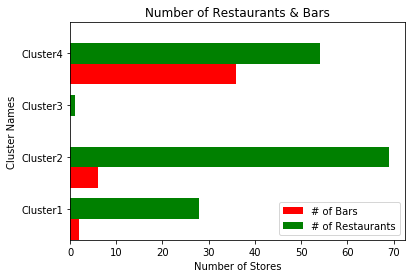

In [149]:
x_axis = ['Cluster1', 'Cluster2', 'Cluster3', 'Cluster4']
bar = [2, 6, 0, 36]
rest = [28, 69, 1, 54]

df = pd.DataFrame(dict(cluster = x_axis,
                           num_of_bars  = bar, num_of_rest= rest)) 

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.num_of_bars, width, color='red', label='# of Bars')
ax.barh(ind + width, df.num_of_rest, width, color='green', label='# of Restaurants')

ax.set(yticks=ind + width, yticklabels=df.cluster, ylim=[2*width - 1, len(df)])
ax.legend()
ax.set_title('Number of Restaurants & Bars')
ax.set_xlabel('Number of Stores')
ax.set_ylabel('Cluster Names')
plt.show()

Graph 1: The graph above shows the number of  bars & restaurants in the four different clusters of Brooklyn

In [133]:
#find the sum of number of bars & restaurants
df["sum"] = df.sum(axis = 1)

In [131]:
df

,cluster,num_of_bars,num_of_rest,Sum
0,Cluster1,2,28,30
1,Cluster2,6,69,75
2,Cluster3,0,1,1
3,Cluster4,36,54,90


Table 2: The table above shows the number of bars & restaurants & the sum of the four clusters in Brooklyn

# <center>Result</center>        
   <p align="right">
    &emsp; The results showed that Cluster 1 had a total of 16 different neighborhoods. Cluster 2 had a total of 27 different neighborhoods. Cluster 3 had a total of 1 neighborhood. Cluster 4 had a total of 26 neighborhoods. Cluster 1 is located mostly on the west of Brooklyn. Cluster 2 is located mostly in the south and eastern parts of Brooklyn. Cluster 3 is in the south by itself in the neighborhood called Sea Gate. Cluster 4 is located mostly on the north of Brooklyn.

 &emsp; From the function Category_Occurrences (to calculate the number of a occurrence of a category in a cluster) it was found out that Cluster 1 had a total of 30 bars & restaurants. 2 coming from bars and 28 coming from restaurants. Cluster 2 had a total of 75 bars & restaurants. 6 coming from bars and 69 coming from restaurants. Cluster 3 had a total of 1 bars & restaurants. 0 coming from bars and 1 coming from restaurants. Cluster 4 had a total of 90 bars & restaurants. 36 coming from bars and 54 coming from restaurants. </p>


# <center>Discussion</center> 
<p align="right">
    &emsp;From the results we can see that the the neighborhoods in Brooklyn were segmented into different clusters inorder to give Client A a variety of locations. Clustering the neighborhoods using KMeans may not have been the best way to solve the problems. However, clustering may have been beneficial to Client A, so that he could choose from more than one neighborhood. The data shows that the neighborhoods Client A will enjoy is mostly in the northern parts of Brooklyn, near the tip of Manhattan. It was also noted that the FourSquare location data did not give the venue names of every single venue in Brooklyn. There was a limit of just 100 venues per neighborhood.The limit in the number of venues was a critical part in determining the categories of stores. It was noted that there were no asian restaurants in Brooklyn, but this is due to the limit in searches from the free FourSquare account. Although the areas with many bars and restaurants were found they were not the same types of restaurants and bars as in Flushing. The data should be further analyzed into giving Client A a more specific area to choose, this can be done by limiting the location radius and finding more specific types of venues.

# <center>Conclusion</center> 
<p align="right">
&emsp;The analysis of the neighborhoods in Brooklyn was conducted so that Client A can be closer to his work. The data from this analysis showed that Client A should move towards the northern part of Brooklyn. The data also showed that Brooklyn is filled with many restaurants and bars, and Client A will have a fun time transitioning to his new neighborhood. Because of the limit in the amount of searches, unfortunately there was a problem in locating every venue. The categories of stores in Flushing and Brooklyn are very different. Client A can also refine his housing research by looking into the housing costs. In conclusion, if money is not an issue, the northern parts of Brooklyn can be a good place for Client A.  